### imports

In [108]:
import pandas as pd
from datetime import datetime, timedelta
import copy
import numpy
import matplotlib.pyplot as plt
import math
from scipy import stats

### Get the data and assign some constants

In [2]:
polls16 = pd.read_csv("president_general_polls_2016.csv")

In [7]:
#final 2016 popular vote share percentage per wikipedia
CLINTON_SHARE=48.2
TRUMP_SHARE=46.1

### Some Exploration and Cleaning

In [4]:
polls16.head()

,cycle,branch,type,matchup,forecastdate,state,startdate,enddate,pollster,grade,...,adjpoll_clinton,adjpoll_trump,adjpoll_johnson,adjpoll_mcmullin,multiversions,url,poll_id,question_id,createddate,timestamp
0,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/8/16,U.S.,11/3/2016,11/6/2016,ABC News/Washington Post,A+,...,45.20163,41.72430,4.626221,NaN,NaN,https://www.washingtonpost.com/news/the-fix/wp...,48630,76192,11/7/16,09:35:33 8 Nov 2016
1,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/8/16,U.S.,11/1/2016,11/7/2016,Google Consumer Surveys,B,...,43.34557,41.21439,5.175792,NaN,NaN,https://datastudio.google.com/u/0/#/org//repor...,48847,76443,11/7/16,09:35:33 8 Nov 2016
2,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/8/16,U.S.,11/2/2016,11/6/2016,Ipsos,A-,...,42.02638,38.81620,6.844734,NaN,NaN,http://projects.fivethirtyeight.com/polls/2016...,48922,76636,11/8/16,09:35:33 8 Nov 2016
3,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/8/16,U.S.,11/4/2016,11/7/2016,YouGov,B,...,45.65676,40.92004,6.069454,NaN,NaN,https://d25d2506sfb94s.cloudfront.net/cumulus_...,48687,76262,11/7/16,09:35:33 8 Nov 2016
4,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/8/16,U.S.,11/3/2016,11/6/2016,Gravis Marketing,B-,...,46.84089,42.33184,3.726098,NaN,NaN,http://www.gravispolls.com/2016/11/final-natio...,48848,76444,11/7/16,09:35:33 8 Nov 2016


Make the dates datetime objects so we can do math with them

In [15]:
polls16["forecastdate"] = pd.to_datetime(polls16["forecastdate"])
polls16["startdate"] = pd.to_datetime(polls16["startdate"])
polls16["enddate"] = pd.to_datetime(polls16["enddate"])
polls16["createddate"] = pd.to_datetime(polls16["createddate"])
polls16["timestamp"] = pd.to_datetime(polls16["timestamp"])

check that all polls are of the presidential race and see if we're mixing state and national polls

In [24]:
print("branch check: " + str(polls16["branch"].unique()))
print("state check: " + str(polls16["state"].unique()))

branch check: ['President']
state check: ['U.S.' 'New Mexico' 'Virginia' 'Iowa' 'Wisconsin' 'North Carolina'
 'Georgia' 'Florida' 'Oregon' 'Ohio' 'South Carolina' 'New York'
 'Michigan' 'Pennsylvania' 'Missouri' 'New Hampshire' 'Arizona' 'Nevada'
 'Colorado' 'California' 'Washington' 'Texas' 'Utah' 'Illinois' 'Indiana'
 'Tennessee' 'Connecticut' 'Massachusetts' 'New Jersey' 'Kansas'
 'Kentucky' 'Minnesota' 'Oklahoma' 'Maryland' 'Alabama' 'Nebraska'
 'Louisiana' 'Maine' 'Arkansas' 'Alaska' 'Vermont' 'Idaho' 'Mississippi'
 'West Virginia' 'South Dakota' 'Montana' 'Hawaii' 'Maine CD-1'
 'Maine CD-2' 'Rhode Island' 'Nebraska CD-3' 'Nebraska CD-1' 'Delaware'
 'North Dakota' 'District of Columbia' 'Nebraska CD-2' 'Wyoming']


Right now I'm too lazy to get vote share totals for individual states but that can be done as a follow on analysis, we'll limit to just national polls for this first look

In [45]:
polls16_nat = polls16[polls16["state"] == "U.S."]

In [47]:
len(polls16_nat)

3318

filter down to just polls in the week leading up to the election

In [48]:
one_week = polls16_nat[polls16_nat["forecastdate"] - polls16_nat["enddate"] <= timedelta(days=7)]

In [50]:
len(one_week)

186

now let's make two different sets of data to examine, raw polling numbers and 538s adjusted polling numbers

In [51]:
one_week.columns

Index(['cycle', 'branch', 'type', 'matchup', 'forecastdate', 'state',
       'startdate', 'enddate', 'pollster', 'grade', 'samplesize', 'population',
       'poll_wt', 'rawpoll_clinton', 'rawpoll_trump', 'rawpoll_johnson',
       'rawpoll_mcmullin', 'adjpoll_clinton', 'adjpoll_trump',
       'adjpoll_johnson', 'adjpoll_mcmullin', 'multiversions', 'url',
       'poll_id', 'question_id', 'createddate', 'timestamp'],
      dtype='object')

In [52]:
ALL_POLL_COLS = ["state", "grade", "samplesize", "pollster"]
RAW_POLL_COLS = ALL_POLL_COLS + ["rawpoll_clinton", "rawpoll_trump"]
ADJ_POLL_COLS = ALL_POLL_COLS + ["adjpoll_clinton", "adjpoll_trump"]

In [60]:
rawdf = copy.deepcopy(one_week[RAW_POLL_COLS])
adjdf = copy.deepcopy(one_week[ADJ_POLL_COLS])

In [61]:
print(len(rawdf))
print(len(adjdf))

186
186


### Compute Error(s)

now we add a column of computed different from final vote share for both raw and adjusted national poll data sets

In [62]:
rawdf["diff_clinton"] = rawdf["rawpoll_clinton"] - CLINTON_SHARE
rawdf["diff_trump"] = rawdf["rawpoll_trump"] - TRUMP_SHARE
adjdf["diff_clinton"] = adjdf["adjpoll_clinton"] - CLINTON_SHARE
adjdf["diff_trump"] = adjdf["adjpoll_trump"] - TRUMP_SHARE

Actually while we're here lets see if each pollster missed both candidates by the same amount?

In [99]:
rawdf["cumulative_diff"] = rawdf["diff_clinton"] - rawdf["diff_trump"]
adjdf["cumulative_diff"] = adjdf["diff_clinton"] - rawdf["diff_trump"]

In [100]:
rawdf.sample(7)

,state,grade,samplesize,pollster,rawpoll_clinton,rawpoll_trump,diff_clinton,diff_trump,cumulative_diff
9328,U.S.,NaN,2526.0,The Times-Picayune/Lucid,45.00,40.00,-3.20,-6.10,2.90
9025,U.S.,A+,1151.0,ABC News/Washington Post,47.00,44.00,-1.20,-2.10,0.90
1092,U.S.,NaN,2988.0,USC Dornsife/LA Times,42.63,48.16,-5.57,2.06,-7.63
8423,U.S.,A-,1282.0,NBC News/Wall Street Journal,44.00,40.00,-4.20,-6.10,1.90
5204,U.S.,C+,1479.0,CVOTER International,49.06,47.82,0.86,1.72,-0.86
4957,U.S.,C+,1500.0,Rasmussen Reports/Pulse Opinion Research,44.00,44.00,-4.20,-2.10,-2.10
5027,U.S.,A-,867.0,IBD/TIPP,44.00,44.10,-4.20,-2.00,-2.20


### Some histograms on the polling missess

<AxesSubplot:>

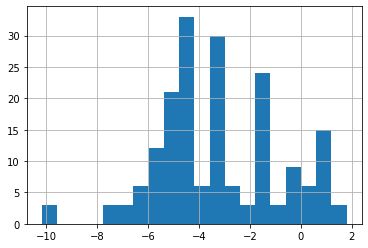

In [101]:
rawdf["diff_clinton"].hist(bins=20)

<AxesSubplot:>

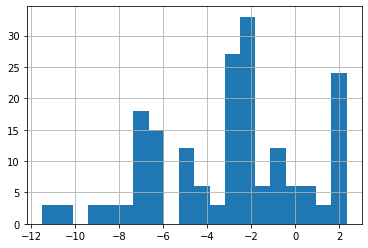

In [102]:
rawdf["diff_trump"].hist(bins=20)

<AxesSubplot:>

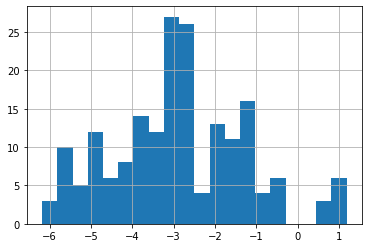

In [103]:
adjdf["diff_clinton"].hist(bins=20)

<AxesSubplot:>

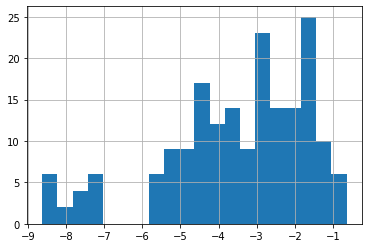

In [104]:
adjdf["diff_trump"].hist(bins=20)

First impressions are:
    - 1) everything missed low for the most part. I don't know what to say about this but maybe over representing Johnson? maybe not wanting to predict undecideds? :shrug emoji:
    - 2) just based on the eye test it looks like the predicted voteshares for Trump did tend to be lower than his final vote share by a bigger magnitude than the predicted voteshares for Clinton were (though both were lower)


Point two would seem to jive with the hindsight knowledge that undecided voters broke heavily for Trump in the final vote (https://www.vox.com/policy-and-politics/2016/12/21/14025198/trump-undecided-final-weeks-survey) If polls were consistently low in predicting each candiates final vote share and assumed undecideds would break evenly when the actually broke more for Trump, this would explain why the polls on average seem to mis lower on trump than clinton

### Cumulative differences (did polsters systemically favor one candidate?)

So, this started as an investigation into if the polling community as a whole has a systemic bias (or at least, that's how it started in my head). My proposed methodology for testing this is to create a "metric" to determine if polsters are systemically biased towards one candidate or another. (Technically this started from a discussion about if pollsters have systemic problems doing turnout modeling and I realize I've gone pretty far a field from that, but! if pollsters as a whole are systemically biased towards one cadidate or another that provides some evidence that they may be systemically biased (as a field) in other ways (like turnout models)
<p>
On to the metric. If the polling community as a whole is systemically biased towards one candidate (and we'd hypothesize a bias towards clinton based on, you know, the most overhyped media narrative surrounding the election) then we would expect that if we subtract the actual voteshare from the predicted voteshare we'd expect a bigger difference for trump than for clinton. If this is true, then we create a metric for each poll of it's bias by subtracting the polling miss for trump by the polling miss for clinton. When the metric is 0, the poll missed both candidates vote shares by the same amount, a positive number indicates the poll missed trump worse than clinton, and a negative number indicates the poll missed clinton worse than trump.
    
I'm making an assumption that this metric will be approximately normally distributed, so let's setup our null hypothesis that the distribution of these "cumulative differences" has a mean of 0 and the alternate hypothesis is that it's not. (1 sample t-test)

but before we get all statistical, let's just try using a mark-1 eyeball

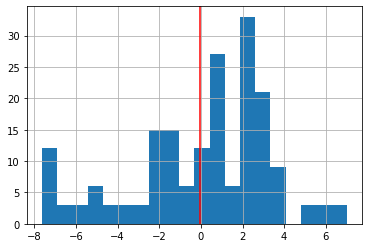

In [105]:
raw_plot = rawdf["cumulative_diff"].hist(bins=20)
raw_plot.axvline(rawdf["cumulative_diff"].mean(), color="red")

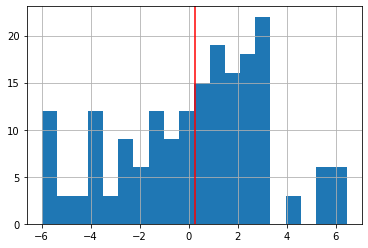

In [106]:
adj_plot = adjdf["cumulative_diff"].hist(bins=20)
adj_plot.axvline(adjdf["cumulative_diff"].mean(), color="red")

well those both look pretty centered around 0 (though I'll admit that my assertions of normality aren't looking perfect) lets try the stats

In [109]:
raw_tstat, raw_pvalue = stats.ttest_1samp(rawdf["cumulative_diff"], 0)
adj_tstat, adj_pvalue = stats.ttest_1samp(adjdf["cumulative_diff"], 0)

Build a table so we can look at the results easier :P

In [121]:
metric = {
    "Raw Polls": {
        "Mean": rawdf["cumulative_diff"].mean(),
        "T Statistic": raw_tstat,
        "P-value": raw_pvalue
    },
    "Adjusted Polls": {
        "Mean": adjdf["cumulative_diff"].mean(),
        "T Statistic": adj_tstat,
        "P-value": adj_pvalue
    }
}

In [122]:
pd.DataFrame(metric).transpose()

,Mean,T Statistic,P-value
Raw Polls,-0.022742,-0.091856,0.926912
Adjusted Polls,0.238506,1.071527,0.285329


so, those p-values don't look great for rejecting the null hypothesis. This doesn't prove it conclusively but it does tell us that in the aggregate the polls published in the week leading up to the election at least weren't systemically biased towards one candidate or the other.